In [17]:
#imports
import torch
import copy
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gym
from collections import deque, namedtuple
import os
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Manager, Lock, Process
import time

In [18]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [26]:
Transition = namedtuple('Transition', 
                        ('observation', 'action', 'next_observation', 'reward', 'done'))

class ReplayMemoryMP(object):

    def __init__(self, capacity):
        manager = Manager()
        self.memory = manager.list()
        self.capacity = capacity
        self.lock = Lock()

    def push(self, *args):
        """save a transtion"""
        with self.lock:
            if len(self.memory) >= self.capacity:
                self.memory.pop(0)
            self.memory.append(Transition(*args))

    def sample(self, batch_size):
        with self.lock:
            return random.sample(list(self.memory), batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
def pick_action(epsilon, policy_net, env, obs):
    p = random.uniform(0,1)
    if p < epsilon:
        action = env.action_space.sample()
    else:
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)

        if obs.ndim == 1:
            obs = obs.unsqueeze(0)

        with torch.no_grad():
            q_values = policy_net(obs)
            action = torch.argmax(q_values).item()
    return action

def error(current_q, td_target, error_type):
    if error_type == "mse":
        compute_loss = nn.MSELoss()
        error = compute_loss(current_q, td_target)
    
    return error

In [21]:
def sample_batch(replay_buffer, batch_size):
    """Return tensors for observations, actions, rewards, next_observations, dones"""
    transitions = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*transitions))

    obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.observation])
    next_obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.next_observation])
    a = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1)
    r = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
    done = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)
    
    return obs, a, r, next_obs, done

In [22]:
class MP_agent():
    def __init__(self, id, replay_buffer, policy_net, target_net, epsilon):
        self.id = id
        self.replay_buffer = replay_buffer
        self.policy_net = policy_net
        self.target_net = target_net
        self.epsilon = epsilon

    def create_environment(self):
        pole_length = random.uniform(0.4, 1.8)
        env = gym.make('CartPole-v1')
        env.unwrapped.length = pole_length
        return env

    def run(self):
        '''
        Run the agent, fill the replay buffer.
        Weights not updated here.
        '''
        env = self.create_environment()
        observation, _ = env.reset()
        terminated = False
        truncated = False
        
        total_reward = 0

        while True:
            #perform an action, get env response
            action = pick_action(self.epsilon, self.policy_net, env, observation)
            next_observation, reward, terminated, truncated, __ = env.step(action)
            next_observation = torch.tensor(next_observation, dtype=torch.float32) 
            total_reward += reward

            #add new data to buffer
            self.replay_buffer.push(observation, action, next_observation, reward, terminated)

            observation = next_observation
            self.epsilon = max(0.01, 0.995 * self.epsilon)
            if terminated or truncated:
                observation, _ = env.reset() 

In [34]:
def MP_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size, n_agents):

    # Initialize the policy network and optimizer
    policy_net = QNetwork(state_dim=4, action_dim=2)
    target_net = QNetwork(state_dim=4, action_dim=2)
    target_net.load_state_dict(policy_net.state_dict())
    policy_net.share_memory()
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    plot_avg_rewards = []

    replay_buffer = ReplayMemoryMP(capacity=capacity) #initialize buffer, its shared between all agents
    step_count = 0 #global step count
    total_reward = 0

    processes = []
    for i in range(n_agents):
        agent = MP_agent(i, replay_buffer, policy_net, target_net, epsilon)
        p = Process(target=agent.run)
        p.start()
        processes.append(p)
    
    time.sleep(1)

    # Training loop
    for episode in range(episodes):
        terminated = False
        truncated = False 
        #step_count = 0

        if len(replay_buffer) < batch_size:
                step_count += 1
                continue 
        
        obs, a , r, obs_next, done = sample_batch(replay_buffer, batch_size)

        if step_count % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        step_count += 1
    
    
        next_q_values = target_net(obs_next)
        next_q_max = next_q_values.max(dim=1, keepdim=True)[0].detach()
        td_target = r + gamma * (1-done) * next_q_max

        current_q = policy_net(obs).gather(1, a)

        loss = error(current_q, td_target, "mse")

        #update weights of the NN/policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for name, param in target_net.named_parameters():
                if param.grad is not None:
                    print(f"{name} has gradient!")


        if episode % 25 == 0:
            # calculate the avg rewards of the last 25 steps
            average = total_reward / 25
            plot_avg_rewards.append(average)
            total_reward = 0
    print('stopping agents:')
    #while not stop_flag.value:
    for p in processes:
        #print(p, end=', ')
        p.terminate()
    for p in processes:
        p.join()

    return plot_avg_rewards, policy_net



In [24]:
def plot_results(learning_rate, gamma, episode, result):

    result = np.array(result)
    
    y = [25*i for i in range(len(result))]
    y_axis = np.array(y)

    #plot graph
    plt.plot(y_axis, result)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Reward')
    plt.title('Average rewards, Learning Rate: {}, Gamma: {}, Episode: {}'.format(learning_rate, gamma, episode))
    plt.show()

    pass

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/RL/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/RL/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'MP_agent' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/RL/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/RL/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'MP_agent' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/RL/lib/python3.10/multiprocessing/

stopping agents:


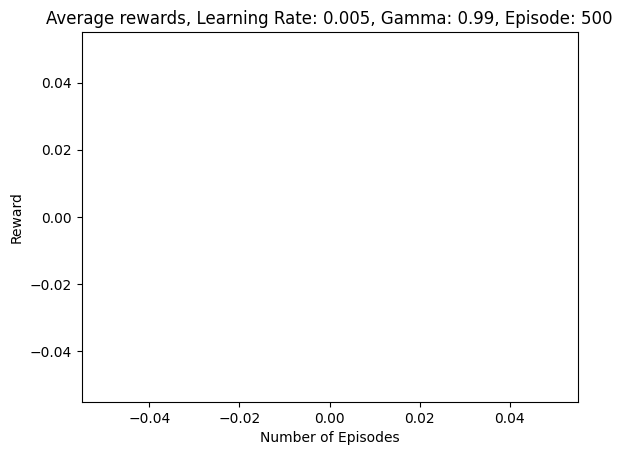

In [37]:
if __name__ == "__main__":
    learning_rate = 0.005
    gamma = 0.99
    episodes = 500
    target_update = 70
    epsilon = 1
    capacity = 10000
    batch_size = 32
    n_agents = 16
    plot_avg_rewards, baseline_network = MP_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size, n_agents)

    plot_results(learning_rate, gamma, episodes, plot_avg_rewards)